In [2]:
#hide
%load_ext autoreload
%autoreload 2

In [3]:
#hide
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from mpl_toolkits import mplot3d

In [4]:
#hide
!pip install mnist

In [5]:
#hide
import mnist

In [6]:
#hide
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [7]:
#hide
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [8]:
#hide
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [9]:
#hide
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

9


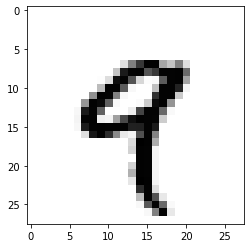

In [10]:
#hide
image_index = 4 
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys');

In [11]:
#hide
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]
y_train

array([3, 3, 3, ..., 8, 3, 8], dtype=uint8)

In [12]:
#hide
X_train = X_train/255.
X_test = X_test/255.

In [13]:
#hide
y_train1 = 1*(y_train==3)
y_test1 = 1*(y_test==3)
y_train1 = y_train1.reshape(-1,1)
y_test1 = y_test1.reshape(-1,1)

In [14]:
#hide
y_test1

array([[1],
       [1],
       [1],
       ...,
       [1],
       [0],
       [1]])

In [15]:
#hide
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

In [16]:
#hide
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

# Config class

In [18]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 220
config.bs = 50

# Importing Functions from kudzu library

In [19]:
from kudzu.data import Data, Sampler, Dataloader
from kudzu.layer import Affine, Sigmoid, Relu
from kudzu.loss import BCE
from kudzu.model import Model
from kudzu.optim import GD
from kudzu.train import Learner
from kudzu.callbacks import AccCallback, take_mean

In [20]:
#hide
layers = [Affine('first',784,100), Relu('first_Relu'), Affine('second',100,100), Relu('second_Relu'), Affine('third',100,2),Affine('fourth',2,1), Sigmoid('sigmoid')]

xavier
xavier
xavier
xavier


In [22]:
#hide
acc = AccCallback
class CLfCallback(acc):
    def __init__(self,learner,bs):
        super().__init__(learner,bs)
        self.accuracies = []
        self.test_accuracies = []
    
    def epoch_end(self, train_prob, test_prob, predicted_test):
        for layer, name, fnval, grval in self.learner.model.params_and_grads():
            self.paramhist[layer.name+'_'+name].append(fnval)
            self.gradhist[layer.name+'_'+name].append(grval)
        eloss = take_mean(self.batch_losses[-self.bpe:], self.bpe, self.afrac)
        self.losses.append(eloss)
        self.accuracies.append(train_prob)
        self.test_accuracies.append(test_prob)
        self.predictions = np.array(predicted_test)
        if self.epoch % 10 ==0:
            print(f"Epoch {self.epoch} Loss {eloss}\n train accuracy: {train_prob} test accuracy: {test_prob}\n\n")
        

    

# Neural Network model

In [25]:
model = Model(layers)
data = Data(X_train, y_train1)
sampler = Sampler(data, config.bs, shuffle = True)
dl = Dataloader(data, sampler)
loss = BCE()
opt = GD(config.lr)


In [26]:
learner = Learner(loss, model, opt, config.num_epochs)
ccb = CLfCallback(learner, config.bs)
learner.set_callbacks([ccb])

# Loop training process begins

In [27]:
#hide_input
learner.train_loop(dl, X_test, y_test1)

Epoch 0 Loss 0.693538771782614
 train accuracy: 0.5075112669003505 test accuracy: 0.514616935483871


Epoch 10 Loss 0.6820724652358695
 train accuracy: 0.6484727090635954 test accuracy: 0.6557459677419355


Epoch 20 Loss 0.41350746130482424
 train accuracy: 0.9011851109998331 test accuracy: 0.9138104838709677


Epoch 30 Loss 0.1590614943280599
 train accuracy: 0.9460857953597063 test accuracy: 0.9571572580645161


Epoch 40 Loss 0.12160038854940354
 train accuracy: 0.9583541979636121 test accuracy: 0.96875


Epoch 50 Loss 0.10706131285513773
 train accuracy: 0.9638624603572025 test accuracy: 0.9702620967741935


Epoch 60 Loss 0.09803540720111434
 train accuracy: 0.9684526790185278 test accuracy: 0.9712701612903226


Epoch 70 Loss 0.09112130871035441
 train accuracy: 0.971290268736438 test accuracy: 0.9712701612903226


Epoch 80 Loss 0.08535107163061283
 train accuracy: 0.9730428976798531 test accuracy: 0.9732862903225806


Epoch 90 Loss 0.08036710209213364
 train accuracy: 0.97537973627

0.024043049702393404

In [30]:
#hide_input
print(f'Maximum train set accuracy is {max(ccb.accuracies)}\n')
print(f'Maximum test set accuracy is {max(ccb.test_accuracies)}')

Maximum train set accuracy is 0.9904857285928893

Maximum test set accuracy is 0.9868951612903226


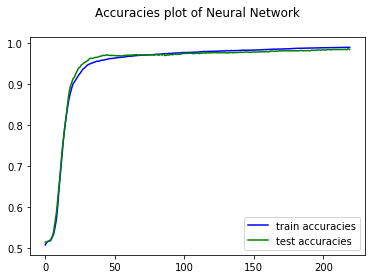

In [31]:
#hide_input
plt.plot(ccb.accuracies, 'b', label = 'train accuracies')
plt.plot(ccb.test_accuracies,'g', label = 'test accuracies')
plt.legend();
plt.title('Accuracies plot of Neural Network\n');

Text(0.5, 1.0, 'Losses plot of Neural Network')

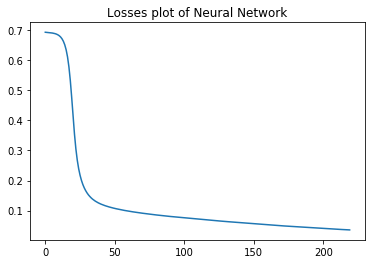

In [32]:
#hide_input
plt.plot(ccb.losses)
plt.title('Losses plot of Neural Network')

In [33]:
#hide
new_model = Model(layers[:-2])
inputs = new_model(X_test)
x1,x2 = np.meshgrid(inputs[:,0], inputs[:,1])
w1 = ccb.get_weights('fourth',0)[-1]
w2 = ccb.get_weights('fourth',1)[-1]
b = ccb.get_biases('fourth')[-1]

In [34]:
#hide
print(x1.max(), x1.min())
print(x2.max(), x2.min())

7.62711352023805 -4.022323625182494
9.306218464102948 -7.889183052603326


In [35]:
#hide
x1grid = np.linspace(-4,4,500)
x2grid = np.linspace(9,-6,500)
X1, X2 = np.meshgrid(x1grid, x2grid)
line = w1*X1 + w2*X2 +b
prob = layers[-1](line)

In [36]:
#hide
y_test.ravel()
b = np.argwhere(y_test ==3)
a = np.argwhere(y_test==8)

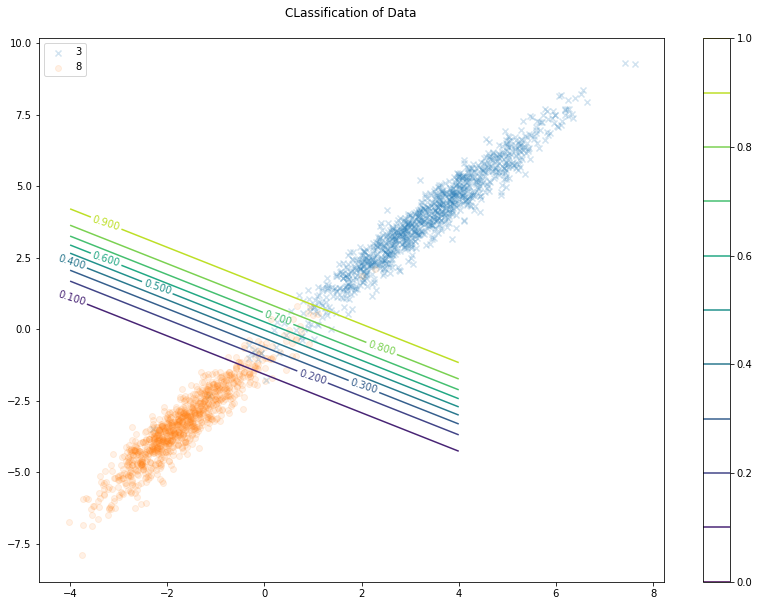

In [37]:
#hide_input
plt.figure(figsize=(14,10))
plt.scatter(inputs[:,0][b],inputs[:,1][b], marker = 'x', alpha = 0.2, label = '3')
plt.scatter(inputs[:,0][a],inputs[:,1][a], marker = 'o', alpha = 0.1, label = '8')
plt.legend(loc = 'upper left')
contours = plt.contour(X1, X2, prob,10)
plt.clabel(contours,inline = True, fontsize = 10);
plt.colorbar(contours);
plt.title('CLassification of Data\n');

# Confusion Matrix for Neural Network

In [38]:
#hide_input
matrix = confusion_matrix(y_test1,ccb.predictions)
print(matrix)
print(f'Number of False positives: {matrix[0,1]}\n')
print(f'Number of False negatives: {matrix[1,0]}')

[[957  17]
 [ 13 997]]
Number of False positives: 17

Number of False negatives: 13


# Logistic Regression model

In [40]:
layers_logistic = [Affine('logistic_aff',784,1),Sigmoid('sigmoid_aff')]
logistic_model = Model(layers_logistic)
learner_logistic = Learner(loss, logistic_model, opt, config.num_epochs)
ccb_logistic = CLfCallback(learner_logistic, config.bs)
learner_logistic.set_callbacks([ccb_logistic])

xavier


In [41]:
# Training process of Logistic Regression model begins

In [42]:
learner_logistic.train_loop(dl, X_test, y_test1)

Epoch 0 Loss 0.711564486873283
 train accuracy: 0.5060924720413954 test accuracy: 0.6995967741935484


Epoch 10 Loss 0.2770448354789408
 train accuracy: 0.9191286930395594 test accuracy: 0.9259072580645161


Epoch 20 Loss 0.21581729067854355
 train accuracy: 0.9374061091637457 test accuracy: 0.9460685483870968


Epoch 30 Loss 0.18853474099288156
 train accuracy: 0.943331664162911 test accuracy: 0.9495967741935484


Epoch 40 Loss 0.17262739956399945
 train accuracy: 0.9478384243031214 test accuracy: 0.954133064516129


Epoch 50 Loss 0.16204190395806053
 train accuracy: 0.9516775162744117 test accuracy: 0.9561491935483871


Epoch 60 Loss 0.15440233380614926
 train accuracy: 0.9539308963445168 test accuracy: 0.9601814516129032


Epoch 70 Loss 0.14857015759711753
 train accuracy: 0.9558504423301619 test accuracy: 0.9596774193548387


Epoch 80 Loss 0.1439373841527812
 train accuracy: 0.956434651977967 test accuracy: 0.9611895161290323


Epoch 90 Loss 0.14015834972710997
 train accuracy: 0.9

0.0497589038823082

In [43]:
#hide_input
print(f'Maximum train set accuracy is {max(ccb_logistic.accuracies)}\n')
print(f'Maximum test set accuracy is {max(ccb_logistic.test_accuracies)}')

Maximum train set accuracy is 0.9633617092305125

Maximum test set accuracy is 0.9667338709677419


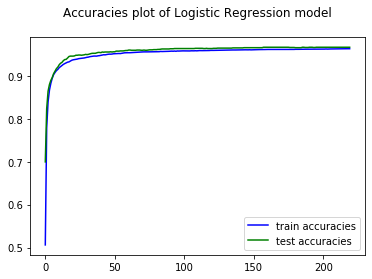

In [44]:
#hide_input
plt.plot(ccb_logistic.accuracies, 'b', label = 'train accuracies')
plt.plot(ccb_logistic.test_accuracies,'g', label = 'test accuracies')
plt.legend();
plt.title('Accuracies plot of Logistic Regression model\n');

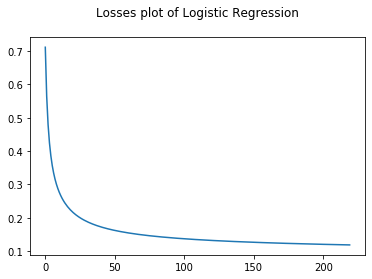

In [45]:
#hide_input
plt.plot(ccb_logistic.losses)
plt.title('Losses plot of Logistic Regression\n');

# Confusion Matrix for Logistic Regression

In [46]:
#hide_input
matrix1 = confusion_matrix(y_test1, ccb_logistic.predictions)
print(matrix1)
print(f'Number of False positives: {matrix1[0,1]}\n')
print(f'Number of False negatives: {matrix1[1,0]}')

[[938  36]
 [ 30 980]]
Number of False positives: 36

Number of False negatives: 30


By these plots we can observe that when performing logistic regression instead of Neural network, our accuracy is less in logistic regression but overfitting doesn't seem to happen in logistic regression
Observing the confusion matrix for both these models we can say that number of false results are also more in case of Logistic Regression model.